In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
import copy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import decomposition
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, RegressorMixin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torch.utils.tensorboard import SummaryWriter

from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig


## Data Acquisition
##### Flat Acquisition using csv files

In [135]:
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')
genome_scores = pd.read_csv('./data/genome-scores.csv')
genome_tags = pd.read_csv('./data/genome-tags.csv')


In [136]:
# print the first 5 rows of the csv files
print('Movies:')
display(movies.head())
print('Ratings:')
display(ratings.head())
print('Tags:')
display(tags.head())
print('Genome Scores:')
display(genome_scores.head())
print('Genome Tags:')
display(genome_tags.head())


Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Tags:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Genome Scores:


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


Genome Tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Data Wrangling

In [137]:
# ratings group by movieId with mean and count
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Dataset merge with movies and ratings, with missing rating films removed
df = pd.merge(movies, grouped_ratings, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013


In [138]:
# Group by tagId and compute mean relevance
mean_relevance = genome_scores.groupby('tagId').mean()['relevance']

# Filter out tags with low mean relevance
threshold = 0.2
good_tags = mean_relevance.where(mean_relevance > threshold).dropna().index
genome_scores_2 = genome_scores[genome_scores['tagId'].isin(good_tags)]

# Merge movies with genome scores
genome_scores_2['tag'] = genome_scores_2['tagId'].map(genome_tags.set_index('tagId')['tag'].to_dict())
genome_table = genome_scores_2.pivot_table(index='movieId', columns='tag', values='relevance')

# Merge movies with genome table
df = pd.merge(df, genome_table, on='movieId')
display(df.head())

,movieId,title,genres,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,...,visceral,visual,visually appealing,visually stunning,weapons,weird,whimsical,witty,women,writers
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,...,0.15150,0.56375,0.3150,0.67325,0.26375,0.42700,0.58700,0.69400,0.08925,0.14125
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,...,0.07325,0.38150,0.2250,0.21700,0.17800,0.38650,0.29250,0.18725,0.13525,0.12225
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,...,0.10175,0.10725,0.1960,0.09850,0.14125,0.24350,0.13025,0.22325,0.35075,0.12200
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,...,0.08800,0.10750,0.2115,0.11625,0.28950,0.21975,0.14775,0.10725,0.97525,0.18200
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,...,0.08275,0.11925,0.1850,0.11875,0.12025,0.29350,0.16425,0.10475,0.40225,0.19225


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning

In [139]:
# print number of rows
print('Number of rows: ', df.shape[0])

# fill rows with missing values (there are films with no tags, so we fill these tag columns set to 0)
df = df.fillna(0)

# print number of rows after dropping missing values
print('Number of rows after dropping missing values: ', df.shape[0])


Number of rows:  13816
Number of rows after dropping missing values:  13816


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [140]:
# one hot encoding for genres
categories = set()
for s in df['genres'].str.split('|').values:
    if s != ['(no genres listed)']:
        categories = categories.union(set(s))

print(categories)

# add columns for each category
for category in categories:
    df[category] = df['genres'].str.contains(category).astype(int)

# delete genres column
df = df.drop(columns=['genres'])

display(df.head())

{'War', 'Musical', 'Adventure', 'IMAX', 'Comedy', 'Action', 'Western', 'Mystery', 'Animation', 'Film-Noir', 'Horror', 'Crime', 'Romance', 'Documentary', 'Sci-Fi', 'Thriller', 'Drama', 'Fantasy', 'Children'}


,movieId,title,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,...,Film-Noir,Horror,Crime,Romance,Documentary,Sci-Fi,Thriller,Drama,Fantasy,Children
0,1,Toy Story (1995),3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,0.89375,...,0,0,0,0,0,0,0,0,1,1
1,2,Jumanji (1995),3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,0.97600,...,0,0,0,0,0,0,0,0,1,1
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,0.32150,...,0,0,0,1,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,0.14875,...,0,0,0,1,0,0,0,1,0,0
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,0.16350,...,0,0,0,0,0,0,0,0,0,0


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset (as expected after merge operation).

In [141]:
# print number of rows
print('Number of rows: ', df.shape[0])

# drop duplicated rows
df = df.drop_duplicates()

# print number of rows after dropping missing values
print('Number of rows after dropping duplicated rows: ', df.shape[0])


Number of rows:  13816
Number of rows after dropping duplicated rows:  13816


## Data Visualization

In [142]:
""" # rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show() """


" # rating distribution from ratings.csv\nsns.countplot(x='rating', data=ratings)\nplt.show()\n\nsns.boxplot(x='rating', data=ratings)\nplt.show() "

Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

In [143]:
""" # rating distribution from df
sns.kdeplot(df['mean_rating'])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show() """


" # rating distribution from df\nsns.kdeplot(df['mean_rating'])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show() "

In [144]:
""" movies_to_show = 5
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")
    

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

fig.suptitle('Rating evolution for the 5 most rated movies')
plt.show() """

' movies_to_show = 5\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\nmost_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == most_rated_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", on=\'date\').mean()[[\'movieId\', \'rating\']].dropna()\n    to_line_plot.append(tmp)\n    movie_title = movies.where(movies[\'movieId\'] == most_rated_movies[i]).dropna()[\'title\'].values[0]\n    axs[i].set_title("Movie: \'" + movie_title + "\'")\n    \n\nfor i in range(movies_to_show):\n    sns.lineplot(x=\'date\', y=\'rating\', ax=axs[i], data=to_line_plot[i])\n\nfig.suptitle(\'Rating evolution for the 5 most rated movies\')\nplt.show() '

In [145]:
""" # Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

# most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index
high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

# Print the titles of the movies
plt.show() """

' # Same as above cell but the 3 movies with the highest standard deviation\nmovies_to_show = 3\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\n# Take movies with at least 1000 ratings\nhigh_std_movies = ratings.where(\n    ratings[\'movieId\']\n    .isin(ratings.groupby(\'movieId\')\n          .count()\n          .where(ratings.groupby(\'movieId\').count()[\'rating\'] > 1000)\n          .dropna().index)\n    ).dropna()\n\n# most_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\nhigh_std_movies = high_std_movies.groupby(\'movieId\').std().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == high_std_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", 

Plot density for every attribute of dataset

In [146]:
""" # print distribution for ratings
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
sns.kdeplot(df['mean_timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(df['rating_count'], ax=axs[1], color='b', label='rating')

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].title.set_text('Timestamp mean distribution')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].title.set_text('Rating count distribution')
plt.show() """


" # print distribution for ratings\nfig, axs = plt.subplots(1, 2, figsize=(10, 2))\nsns.kdeplot(df['mean_timestamp'], ax=axs[0], color='r', label='timestamp')\nsns.kdeplot(df['rating_count'], ax=axs[1], color='b', label='rating')\n\naxs[0].set_xlabel('')\naxs[0].set_ylabel('')\naxs[0].title.set_text('Timestamp mean distribution')\naxs[1].set_xlabel('')\naxs[1].set_ylabel('')\naxs[1].title.set_text('Rating count distribution')\nplt.show() "

In [147]:
""" # density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0]) """

" # density plot for rating_count\nfig, axs = plt.subplots(1,2, figsize=(10, 5))\nsns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')\nsns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')\n\nprint('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])\nprint('Number of all movies: ', df.shape[0]) "

In [148]:
""" # plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
plt.xticks([])
plt.show() """


' # plot for categories\ncat = list(categories)\n\n# count the number of rows containing 1 for each category\ncat_dict = {}\nfor category in cat:\n    cat_dict[category] = df[category].sum()\n\n# order the dictionary by value in descending order\ncat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}\n\n# plot an histogram of the number of rows for each category\nfig, axs = plt.subplots(1, 1, figsize=(20, 10))\nax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))\nax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))\nplt.xticks([])\nplt.show() '

In [149]:
""" # plot for tags

tag_columns = list(df.columns)
tag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns
tag_columns = [tag for tag in tag_columns if tag not in categories]

tag_dict = {}
for tag in tag_columns:
    tag_dict[tag] = df[tag].mean()

# order the dictionary by value in descending order
tag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}

display('Tag mean: ', tag_dict)

# plot tag mean
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(tag_dict.keys()), y=list(tag_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(tag_dict.keys()))
plt.xticks([])
plt.show() """


" # plot for tags\n\ntag_columns = list(df.columns)\ntag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns\ntag_columns = [tag for tag in tag_columns if tag not in categories]\n\ntag_dict = {}\nfor tag in tag_columns:\n    tag_dict[tag] = df[tag].mean()\n\n# order the dictionary by value in descending order\ntag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}\n\ndisplay('Tag mean: ', tag_dict)\n\n# plot tag mean\nfig, axs = plt.subplots(1, 1, figsize=(20, 10))\nax = sns.barplot(x=list(tag_dict.keys()), y=list(tag_dict.values()))\nax.bar_label(container=ax.containers[0], labels=list(tag_dict.keys()))\nplt.xticks([])\nplt.show() "

In [150]:
""" # count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum()) """


" # count the number of rows containing 1 for Film-Noir and IMAX\nprint('Number of Film-Noir movies: ', df['Film-Noir'].sum())\nprint('Number of IMAX movies: ', df['IMAX'].sum()) "

## Data Preprocessing

In [151]:
# from title extract year
df['year'] = df['title'].str.extract('(\(\d{4}\))', expand=True)
# remove parentheses
df['year'] = df['year'].str.extract('(\d{4})', expand=True)

# remove movies with no year
df = df.dropna(subset=['year'])

# convert year to int
df['year'] = df['year'].astype(int)

# delete title and movieId columns
df = df.drop(columns=['movieId', 'title'])

display(df.head())

,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,affectionate,allegory,...,Horror,Crime,Romance,Documentary,Sci-Fi,Thriller,Drama,Fantasy,Children,year
0,3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,0.89375,0.67625,0.24600,...,0,0,0,0,0,0,0,1,1,1995
1,3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,0.97600,0.12675,0.17750,...,0,0,0,0,0,0,0,1,1,1995
2,3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,0.32150,0.09550,0.10775,...,0,0,1,0,0,0,0,0,0,1995
3,2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,0.14875,0.13150,0.07750,...,0,0,1,0,0,0,1,0,0,1995
4,3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,0.16350,0.11875,0.06975,...,0,0,0,0,0,0,0,0,0,1995


In [152]:
""" # density plot for film year
sns.kdeplot(df['year'])
plt.show() """

" # density plot for film year\nsns.kdeplot(df['year'])\nplt.show() "

In [153]:
""" # Compute the number of unique values for each column
unique_values = {}
for column in df.columns:
    if column == 'mean_rating' or column == 'mean_timestamp' or column == 'year':
        unique_values[column] = np.unique(df[column], return_counts=True)

# Print the number of unique values for each column
for column in unique_values:
    print(column, ':', unique_values[column])

# Plot the number of unique values for each column
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))
sns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0])
axs[0].set_xlabel('mean rating')
axs[0].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['mean_timestamp'][0], y=unique_values['mean_timestamp'][1], ax=axs[1])
axs[1].set_xlabel('mean timestamp')
axs[1].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[2])
axs[2].set_xlabel('year')
axs[2].set_ylabel('number of unique values')
plt.show() """


" # Compute the number of unique values for each column\nunique_values = {}\nfor column in df.columns:\n    if column == 'mean_rating' or column == 'mean_timestamp' or column == 'year':\n        unique_values[column] = np.unique(df[column], return_counts=True)\n\n# Print the number of unique values for each column\nfor column in unique_values:\n    print(column, ':', unique_values[column])\n\n# Plot the number of unique values for each column\nfig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))\nsns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0])\naxs[0].set_xlabel('mean rating')\naxs[0].set_ylabel('number of unique values')\nsns.lineplot(x=unique_values['mean_timestamp'][0], y=unique_values['mean_timestamp'][1], ax=axs[1])\naxs[1].set_xlabel('mean timestamp')\naxs[1].set_ylabel('number of unique values')\nsns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[2])\naxs[2].set_xlabel('year')\naxs[2].set_ylabel('number

In [154]:
""" # show year and year_timestamp in the same plot with values from 2000 to 2020
df_year = df.copy()
df_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')
df_year['year_timestamp'] = df_year['mean_timestamp'].dt.year

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[0], label='film year')
axs[0].set_xlabel('year')
sns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[1], label='film year')
axs[1].set_xlabel('year')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
plt.show() """


" # show year and year_timestamp in the same plot with values from 2000 to 2020\ndf_year = df.copy()\ndf_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')\ndf_year['year_timestamp'] = df_year['mean_timestamp'].dt.year\n\nfig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))\nsns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year')\nsns.kdeplot(df_year['year'], ax=axs[0], label='film year')\naxs[0].set_xlabel('year')\nsns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year')\nsns.kdeplot(df_year['year'], ax=axs[1], label='film year')\naxs[1].set_xlabel('year')\naxs[1].set_xlim(2000, 2020)\naxs[1].set_xticks(np.arange(2000, 2022, 4))\nplt.show() "

In [155]:
# Drop columns that are in cat but not in lower_case_tags
lower_case_tags = [str.lower(t) for t in genome_tags['tag'].values]
cat = list(categories)
for c in cat:
    if c.lower() in lower_case_tags:
        df = df.drop(columns=[c])
        # print('Dropped column', c)

display(df.head())


,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,affectionate,allegory,...,visually stunning,weapons,weird,whimsical,witty,women,writers,IMAX,Film-Noir,year
0,3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,0.89375,0.67625,0.24600,...,0.67325,0.26375,0.42700,0.58700,0.69400,0.08925,0.14125,0,0,1995
1,3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,0.97600,0.12675,0.17750,...,0.21700,0.17800,0.38650,0.29250,0.18725,0.13525,0.12225,0,0,1995
2,3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,0.32150,0.09550,0.10775,...,0.09850,0.14125,0.24350,0.13025,0.22325,0.35075,0.12200,0,0,1995
3,2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,0.14875,0.13150,0.07750,...,0.11625,0.28950,0.21975,0.14775,0.10725,0.97525,0.18200,0,0,1995
4,3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,0.16350,0.11875,0.06975,...,0.11875,0.12025,0.29350,0.16425,0.10475,0.40225,0.19225,0,0,1995


In [156]:
""" # TODO - balancing dataset only for training set
# remove samples_to_drop movies with mean_rating between 2.5 and 4
samples_to_drop = 25000
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)

# rating distribution from df
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df['mean_rating'], ax=axs[0])
sns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

# number of samples in df and df_preprocessed
print('Number of samples in df: ', df.shape[0])
print('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) """


" # TODO - balancing dataset only for training set\n# remove samples_to_drop movies with mean_rating between 2.5 and 4\nsamples_to_drop = 25000\ndf_preprocessed = df.copy()\ndf_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)\n\n# rating distribution from df\nfig, axs = plt.subplots(1, 2, figsize=(10, 5))\nsns.kdeplot(df['mean_rating'], ax=axs[0])\nsns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show()\n\n# number of samples in df and df_preprocessed\nprint('Number of samples in df: ', df.shape[0])\nprint('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) "

### Normalization

In [157]:
""" # TODO - fit the model to raw, scaled and standardized data and compare the performance for best results

mean_rating_column = df['mean_rating']

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.drop(columns=['mean_rating']))

# show normalized data
df = pd.DataFrame(normalized_data, columns=df.columns[:-1])
df['mean_rating'] = mean_rating_column
df = df.dropna()
mean_rating_column = df['mean_rating']
display(df.shape)
 """

" # TODO - fit the model to raw, scaled and standardized data and compare the performance for best results\n\nmean_rating_column = df['mean_rating']\n\nscaler = MinMaxScaler()\nnormalized_data = scaler.fit_transform(df.drop(columns=['mean_rating']))\n\n# show normalized data\ndf = pd.DataFrame(normalized_data, columns=df.columns[:-1])\ndf['mean_rating'] = mean_rating_column\ndf = df.dropna()\nmean_rating_column = df['mean_rating']\ndisplay(df.shape)\n "

In [158]:
# normalize columns
df = df.dropna()
mean_rating_column = df['mean_rating']
df = df.drop(columns=['mean_rating'])
df = (df - df.min()) / (df.max() - df.min())
df['mean_rating'] = mean_rating_column
display(df.head())


,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,affectionate,allegory,art,...,weapons,weird,whimsical,witty,women,writers,IMAX,Film-Noir,year,mean_rating
0,0.703135,0.407213,0.077959,0.659114,0.266008,0.246281,0.894423,0.692328,0.227026,0.179024,...,0.232614,0.399206,0.602350,0.745690,0.063775,0.108818,0.0,0.0,0.804878,3.893708
1,0.297024,0.363590,0.135198,0.636200,0.489140,0.457226,0.979767,0.110847,0.156096,0.125549,...,0.141220,0.356349,0.280404,0.163218,0.111283,0.088448,0.0,0.0,0.804878,3.251527
2,0.144504,0.163159,0.088060,0.141864,0.192948,0.148247,0.300649,0.077778,0.083873,0.069491,...,0.102052,0.205026,0.103034,0.204598,0.333850,0.088180,0.0,0.0,0.804878,3.142028
3,0.030568,0.109211,0.108780,0.128218,0.480677,0.433050,0.121401,0.115873,0.052550,0.149574,...,0.260059,0.179894,0.122165,0.071264,0.978828,0.152506,0.0,0.0,0.804878,2.853547
4,0.143399,0.197275,0.130536,0.137230,0.234979,0.152763,0.136706,0.102381,0.044525,0.071558,...,0.079670,0.257937,0.140202,0.068391,0.387038,0.163495,0.0,0.0,0.804878,3.058434


### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

<!-- Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production. -->

### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables (i.e. variables are indipendent).

<!-- In the table provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

As it's possible to see in the table, variables tend to be indipendent from each others, this is not valid only for two variables: rating_count and mean_timestamp. These two attributes are highly dipendent with all other attributes. -->

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96.

<!-- The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09. -->


In [159]:
""" # compute analysis for 'mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX'
corr = df[['mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX']].corr()
print(corr)
cov = df[['mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX']].cov()
print(cov)
desc = df[['mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX']].describe()
print(desc)

# follow examples from slides on Data Visualization (pages 6-8)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# show results of correlation in a graphic way
# Plot the heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])
# show results of covariance in a graphic way
# Plot the heatmap of the covariance matrix
sns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)

plt.show()

# Plot the table
plt.figure(figsize=(10, 5))
sns.heatmap(desc, annot=True, cmap='Reds', vmax=1, vmin=0)
plt.show() """




' # compute analysis for \'mean_rating\', \'rating_count\', \'mean_timestamp\', \'Film-Noir\', \'IMAX\'\ncorr = df[[\'mean_rating\', \'rating_count\', \'mean_timestamp\', \'Film-Noir\', \'IMAX\']].corr()\nprint(corr)\ncov = df[[\'mean_rating\', \'rating_count\', \'mean_timestamp\', \'Film-Noir\', \'IMAX\']].cov()\nprint(cov)\ndesc = df[[\'mean_rating\', \'rating_count\', \'mean_timestamp\', \'Film-Noir\', \'IMAX\']].describe()\nprint(desc)\n\n# follow examples from slides on Data Visualization (pages 6-8)\nfig, axs = plt.subplots(2, 1, figsize=(10, 10))\n# show results of correlation in a graphic way\n# Plot the heatmap of the correlation matrix\nsns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])\n# show results of covariance in a graphic way\n# Plot the heatmap of the covariance matrix\nsns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)\n\nplt.show()\n\n# Plot the table\nplt.figure(figsize=(10, 5))\nsns.heatmap(desc, annot=True, cmap=\'Reds\', vmax=1, vmin=0)

In [160]:
""" # compute analysis for other attributes
corr = df.corr()
cov = df.cov()
desc = df.describe()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(50, 50))
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

# Plot the heatmap of the covariance matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cov, cmap="YlGnBu", vmax=1, vmin=-1)
plt.show()

# Plot the table
plt.figure(figsize=(50, 50))
sns.heatmap(desc, cmap='Reds', vmax=1, vmin=0)
plt.show() """



' # compute analysis for other attributes\ncorr = df.corr()\ncov = df.cov()\ndesc = df.describe()\n\n# Plot the heatmap of the correlation matrix\nplt.figure(figsize=(50, 50))\nsns.heatmap(corr, cmap="YlGnBu")\nplt.show()\n\n# Plot the heatmap of the covariance matrix\nplt.figure(figsize=(50, 50))\nsns.heatmap(cov, cmap="YlGnBu", vmax=1, vmin=-1)\nplt.show()\n\n# Plot the table\nplt.figure(figsize=(50, 50))\nsns.heatmap(desc, cmap=\'Reds\', vmax=1, vmin=0)\nplt.show() '

In [161]:
# save df as csv file
df.to_csv('dataset.csv', index=False)

### PCA (Principal Component Analysis)

In [162]:
""" df_PCA = df.copy()

mean_rating_column = df_PCA['mean_rating']
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(df.drop(columns=['mean_rating']), mean_rating_column, test_size=0.1, random_state=42)
print('X shape:',df.drop(columns=['mean_rating']).shape)
print('y shape:',mean_rating_column.shape)
print('X_train shape:',X_train_PCA.shape)
print('y_train shape:',y_train_PCA.shape)
print('X_test shape:',X_test_PCA.shape)
print('y_test shape:',y_test_PCA.shape)

pca = decomposition.PCA()
pca.fit(X_train_PCA)
print('pca.mean_:', pca.mean_)
print('pca.explained_variance_:', pca.explained_variance_)
print('pca.explained_variance_ratio_:', pca.explained_variance_ratio_)
print('pca.components_:', pca.components_)

X_train_PCA = pca.transform(X_train_PCA)
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=y_train_PCA)
plt.show()
X_test_PCA = pca.transform(X_test_PCA)
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=y_test_PCA)
plt.show() """


" df_PCA = df.copy()\n\nmean_rating_column = df_PCA['mean_rating']\nX_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(df.drop(columns=['mean_rating']), mean_rating_column, test_size=0.1, random_state=42)\nprint('X shape:',df.drop(columns=['mean_rating']).shape)\nprint('y shape:',mean_rating_column.shape)\nprint('X_train shape:',X_train_PCA.shape)\nprint('y_train shape:',y_train_PCA.shape)\nprint('X_test shape:',X_test_PCA.shape)\nprint('y_test shape:',y_test_PCA.shape)\n\npca = decomposition.PCA()\npca.fit(X_train_PCA)\nprint('pca.mean_:', pca.mean_)\nprint('pca.explained_variance_:', pca.explained_variance_)\nprint('pca.explained_variance_ratio_:', pca.explained_variance_ratio_)\nprint('pca.components_:', pca.components_)\n\nX_train_PCA = pca.transform(X_train_PCA)\nplt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=y_train_PCA)\nplt.show()\nX_test_PCA = pca.transform(X_test_PCA)\nplt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=y_test_PCA)\nplt.show() "

## Modeling

In [163]:
# Split data
X = df.drop(columns=['mean_rating'])
y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


#### Linear Regressor

In [164]:
# Create Linear Regression model in sklearn

# Create the model
LR_model = LinearRegression()

# Train the model on the training data
LR_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = LR_model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))


Mean squared error: 0.01
Coefficient of determination: 0.96


#### Stochastic Gradient Descent

In [165]:
""" # Create Stochastic Gradient Descent model in sklearn

# Create the model
SGD_model = SGDRegressor()

# Train the model on the training data
SGD_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = SGD_model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred)) """


" # Create Stochastic Gradient Descent model in sklearn\n\n# Create the model\nSGD_model = SGDRegressor()\n\n# Train the model on the training data\nSGD_model.fit(X_train, y_train)\n\n# Evaluate the model on the test data\ny_pred = SGD_model.predict(X_test)\nprint('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))\nprint('Coefficient of determination: %.2f' % r2_score(y_test, y_pred)) "

#### SVM

In [166]:
""" # Create SVM model in sklearn

# Create the model
SVM_model = SVR()

# Train the model on the training data
SVM_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = SVM_model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

display(y_test[:5])
display(y_pred[:5]) """


" # Create SVM model in sklearn\n\n# Create the model\nSVM_model = SVR()\n\n# Train the model on the training data\nSVM_model.fit(X_train, y_train)\n\n# Evaluate the model on the test data\ny_pred = SVM_model.predict(X_test)\nprint('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))\nprint('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))\n\ndisplay(y_test[:5])\ndisplay(y_pred[:5]) "

### KNN

In [167]:
""" KNN_model = KNeighborsRegressor(n_neighbors=5)
KNN_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = KNN_model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

display(y_test[:5])
display(y_pred[:5]) """


" KNN_model = KNeighborsRegressor(n_neighbors=5)\nKNN_model.fit(X_train, y_train)\n\n# Evaluate the model on the test data\ny_pred = KNN_model.predict(X_test)\nprint('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))\nprint('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))\n\ndisplay(y_test[:5])\ndisplay(y_pred[:5]) "

### Decision Trees

In [168]:
""" DT_model = DecisionTreeRegressor()
DT_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = DT_model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred)) """


" DT_model = DecisionTreeRegressor()\nDT_model.fit(X_train, y_train)\n\n# Evaluate the model on the test data\ny_pred = DT_model.predict(X_test)\nprint('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))\nprint('Coefficient of determination: %.2f' % r2_score(y_test, y_pred)) "

### Modeling the problem as classification

In [169]:
# bin y_train and y_test into 10 bins
y_train_binned = pd.cut(y_train, 10, labels=False)
y_test_binned = pd.cut(y_test, 10, labels=False)

""" print('Binned values:', np.unique(y_train_binned))
display(y_train_binned[:5]) """

# use the binned values to train the model

RFC_classifier = RandomForestClassifier()
RFC_classifier.fit(X_train, y_train_binned)

y_pred = RFC_classifier.predict(X_test)

# evaluation of y_pred
print('Accuracy: %.2f' % accuracy_score(y_test_binned, y_pred))
print('Recall: %.2f' % recall_score(y_test_binned, y_pred, average='macro'))
print('Precision: %.2f' % precision_score(y_test_binned, y_pred, average='macro'))

""" display(y_test_binned[:5])
display(y_pred[:5]) """

Accuracy: 0.65
Recall: 0.35
Precision: 0.47


' display(y_test_binned[:5])\ndisplay(y_pred[:5]) '

### NN

In [170]:
import pandas as pd
import numpy as np
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import decomposition

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torch.utils.tensorboard import SummaryWriter


In [171]:
df = pd.read_csv('dataset.csv')


In [172]:
#look for GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print("Device: {}".format(device))


Device: mps


In [173]:
# reproducibility -> il risultato tra un run e il successivo è lo stesso
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)


In [174]:
# training process
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, writer):
    n_iter = 0
    patience = 10
    best_loss = np.inf
    best_model = None

    for epoch in range(epochs):
        model.train()
        # per verificare che ci troviamo in training e non in validation per evitare che il modello aggiorni i pesi
        for data, targets in data_loader:
            # per spostare il minibatch in GPU
            data, targets = data.to(device), targets.to(device)
            # Forward pass -> chiama la funzione forward
            y_pred = model(data)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)
            # serve per azzerare il gradiente
            optimizer.zero_grad()
            # la barra separa Loss e la sezione train
            writer.add_scalar("Loss/train", loss, n_iter)
            # Backward pass
            loss.backward()
            # aggiorna i pesi della rete
            optimizer.step()
            n_iter += 1

        
        # validation
        loss_val, _, _ = test_model(model, criterion, val_loader, device)

        # early stopping
        if loss_val < best_loss:
            best_loss = loss_val
            best_model = copy.deepcopy(model)
            best_epoch = epoch+1
            patience = 10
        else:
            patience = patience - 1
            if patience == 0:
                print("\nEarly stopping", end='')
                return best_model, best_epoch

        print("Epoch: [{}/{}],\tPatience: {},\tLoss: {:.4f},\tVal Loss: {:.4f}".format(epoch+1, epochs, patience, loss, loss_val), end='\r')
        writer.add_scalar("Loss/val", loss_val, epoch)
    
    return best_model, best_epoch



#evaluation process -> utilizzata sia per la validation che per il test
def test_model(model, criterion, data_loader, device):
    # model.eval() # per evitare che il modello aggiorni i pesi
    loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    num_samples = 0
    
    for data, targets in data_loader:
        num_samples += 1
        data, targets = data.to(device), targets.to(device)
        output = model(data)
        loss += criterion(output.squeeze(), targets)
        y_pred = torch.cat((y_pred, output), 0)
        y_true = torch.cat((y_true, targets), 0)

    return loss/num_samples, y_pred.squeeze(), y_true


""" def test_model(model, criterion, loader):
    loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    i = 0

    for _, (x, y) in enumerate(loader):
        i += 1
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss += criterion(output.squeeze(), y)
        y_pred = torch.cat((y_pred, output), 0)
        y_true = torch.cat((y_true, y), 0)

    return loss /i, y_pred.squeeze(), y_true """

' def test_model(model, criterion, loader):\n    loss = 0\n    y_pred = torch.tensor([]).to(device)\n    y_true = torch.tensor([]).to(device)\n    i = 0\n\n    for _, (x, y) in enumerate(loader):\n        i += 1\n        x = x.to(device)\n        y = y.to(device)\n        output = model(x)\n        loss += criterion(output.squeeze(), y)\n        y_pred = torch.cat((y_pred, output), 0)\n        y_true = torch.cat((y_true, y), 0)\n\n    return loss /i, y_pred.squeeze(), y_true '

In [175]:
""" class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dp = dropout_prob
        
        model = [
            nn.Linear(self.input_size, self.hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(self.dp)
        ]
        
        for i in range(1, len(self.hidden_sizes)):
            model.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
            model.append(nn.ReLU())
            model.append(nn.Dropout(self.dp))
        
        model.append(nn.Linear(self.hidden_sizes[-1], 1))
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x.squeeze()
 """

' class NN(nn.Module):\n    def __init__(self, input_size, hidden_sizes, dropout_prob=0):\n        super(NN, self).__init__()\n        self.input_size = input_size\n        self.hidden_sizes = hidden_sizes\n        self.dp = dropout_prob\n        \n        model = [\n            nn.Linear(self.input_size, self.hidden_sizes[0]),\n            nn.ReLU(),\n            nn.Dropout(self.dp)\n        ]\n        \n        for i in range(1, len(self.hidden_sizes)):\n            model.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))\n            model.append(nn.ReLU())\n            model.append(nn.Dropout(self.dp))\n        \n        model.append(nn.Linear(self.hidden_sizes[-1], 1))\n        \n        self.model = nn.Sequential(*model)\n\n    def forward(self, x):\n        x = self.model(x)\n        return x.squeeze()\n '

In [176]:
def get_model(input_size, hidden_sizes, dropout_prob=0):
    model = [
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Dropout(dropout_prob)
    ]
    
    for i in range(1, len(hidden_sizes)):
        model.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        model.append(nn.ReLU())
        model.append(nn.Dropout(dropout_prob))
    
    model.append(nn.Linear(hidden_sizes[-1], 1))
    
    return nn.Sequential(*model)

In [177]:
""" class RatingDataset(Dataset):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        
        self.num_features = X_train.shape[1]
        
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
        self.X_val = X_val.to_numpy()
        self.y_val = y_val.to_numpy()
        self.X_test = X_test.to_numpy()
        self.y_test = y_test.to_numpy()

        self.val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=y_val.shape[0], shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=y_test.shape[0], shuffle=False)
    
    def get_train_loader(self, batch_size):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_train, dtype=torch.float32), torch.tensor(self.y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx] """


' class RatingDataset(Dataset):\n    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):\n        \n        self.num_features = X_train.shape[1]\n        \n        self.X_train = X_train.to_numpy()\n        self.y_train = y_train.to_numpy()\n        self.X_val = X_val.to_numpy()\n        self.y_val = y_val.to_numpy()\n        self.X_test = X_test.to_numpy()\n        self.y_test = y_test.to_numpy()\n\n        self.val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=y_val.shape[0], shuffle=False)\n        self.test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=y_test.shape[0], shuffle=False)\n    \n    def get_train_loader(self, batch_size):\n        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch

In [178]:
X = df.drop('mean_rating', axis=1)
Y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# PCA
pca = decomposition.PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)), batch_size=y_val.shape[0], shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)), batch_size=y_test.shape[0], shuffle=False)

In [179]:
#hyperparameters
hidden_sizes = [[16, 16, 16], [32, 32, 32], [64, 64, 64],
                [16, 8, 16], [32, 16, 32], [64, 32, 64],
                [16, 32, 16], [32, 64, 32]]
nums_epochs = [200]
batch_sizes = [64, 128, 256, 512]
learning_rate = [0.1, 0.01, 0.001]
dropout_prob = [0.0, 0.1, 0.2]

# crea tutte le possibili combinazioni di iperparametri
hyperparameters = itertools.product(hidden_sizes, nums_epochs, batch_sizes, learning_rate, dropout_prob)


""" # data
my_dataset = RatingDataset(X_train, y_train, X_val, y_val, X_test, y_test)
val_loader = my_dataset.val_loader
test_loader = my_dataset.test_loader """

my_table = pd.DataFrame(columns=['hidden_size', 'num_epochs', 'batch_size', 'learning_rate', 'dropout_prob', 'MSE'])

#grid search loop
for i, [hidden_size, num_epochs, batch, learning_rate, dropout_prob] in enumerate(hyperparameters):
    print("\nhidden_size: {}, num_epochs: {}, batch_size: {}, learning_rate: {}, dropout_prob: {}".format(hidden_size, num_epochs, batch, learning_rate, dropout_prob))
    
    log_name = "dim:"+str(hidden_size)+"-ep:"+str(num_epochs)+"-bs:"+str(batch) + "-lr:"+str(learning_rate)

    #start tensorboard
    writer = SummaryWriter('runs/'+log_name)

    """ #changing the batch size changes the number of updates
    train_loader = my_dataset.get_train_loader(batch)

    #define architecture, loss and optimizer
    model = NN(my_dataset.num_features, hidden_size, dropout_prob) """

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=batch, shuffle=True)
    # model = NN(X_train.shape[1], hidden_size, dropout_prob)
    model = get_model(X_train.shape[1], hidden_size, dropout_prob)
    
    criterion = torch.nn.MSELoss()

    #train and validate
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    model, n_epochs = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)

    mse, y_t, y_p = test_model(model, criterion, test_loader, device)
    print("\nMSE: {}".format(mse))
    r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
    print("R2: {}".format(r2))

    my_table.loc[my_table.shape[0]] = [hidden_size, n_epochs, batch, learning_rate, dropout_prob, mse.item()]

    writer.add_scalar('metrics/test mse', mse.item())
    
    
    """ writer.add_hparams(
        {'lr': learning_rate, 'bsize': batch, 'dim': hidden_size, 'num_epochs': num_epochs},
        {'hparam/mse': mse.item()}) """
    

    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), 'models/'+log_name)


    writer.flush()
    
writer.close()



hidden_size: [16, 16, 16], num_epochs: 200, batch_size: 64, learning_rate: 0.1, dropout_prob: 0.0
Epoch: [20/200],	Patience: 1,	Loss: 0.0124,	Val Loss: 0.01188
Early stopping
MSE: 0.008539647795259953
R2: 0.9617724264344155

hidden_size: [16, 16, 16], num_epochs: 200, batch_size: 64, learning_rate: 0.1, dropout_prob: 0.1
Epoch: [12/200],	Patience: 1,	Loss: 0.1280,	Val Loss: 0.2342
Early stopping
MSE: 0.2255687117576599
R2: -992061683191.0276

hidden_size: [16, 16, 16], num_epochs: 200, batch_size: 64, learning_rate: 0.1, dropout_prob: 0.2
Epoch: [29/200],	Patience: 1,	Loss: 0.0211,	Val Loss: 0.03210
Early stopping
MSE: 0.036381401121616364
R2: 0.7910628483849035

hidden_size: [16, 16, 16], num_epochs: 200, batch_size: 64, learning_rate: 0.01, dropout_prob: 0.0
Epoch: [73/200],	Patience: 1,	Loss: 0.0101,	Val Loss: 0.00854
Early stopping
MSE: 0.008308878168463707
R2: 0.9614074370194334

hidden_size: [16, 16, 16], num_epochs: 200, batch_size: 64, learning_rate: 0.01, dropout_prob: 0.1
Ep

In [180]:
# from my_table to csv
my_table.to_csv('my_table.csv', index=False)


In [220]:
# apply green color to min MSE
my_table.style.applymap(lambda x: 'background-color: green' if x == my_table['MSE'].min() else '', subset=['MSE'])



,hidden_size,num_epochs,batch_size,learning_rate,dropout_prob,MSE
0,"[16, 16, 16]",20,64,0.100000,0.000000,0.008540
1,"[16, 16, 16]",12,64,0.100000,0.100000,0.225569
2,"[16, 16, 16]",29,64,0.100000,0.200000,0.036381
3,"[16, 16, 16]",73,64,0.010000,0.000000,0.008309
4,"[16, 16, 16]",83,64,0.010000,0.100000,0.018760
5,"[16, 16, 16]",33,64,0.010000,0.200000,0.033214
6,"[16, 16, 16]",200,64,0.001000,0.000000,0.008473
7,"[16, 16, 16]",71,64,0.001000,0.100000,0.031390
8,"[16, 16, 16]",69,64,0.001000,0.200000,0.042185
9,"[16, 16, 16]",42,128,0.100000,0.000000,0.008296


In [219]:
""" # from analysis_output.txt take epoch array where epoch is x in line "Epoch: [x/y],	Patience: z,	Loss: a,	Val Loss: b"
analysis_output = open("analysis_output.txt", "r")
analysis_output = analysis_output.read()
analysis_output = analysis_output.split("\n")
analysis_output = [x for x in analysis_output]

epochs_array = []
for line in analysis_output:
    if line.startswith("Epoch: ["):
        # extract x from line "Epoch: [x/y],	Patience: z,	Loss: a,	Val Loss: b"
        line = line.split("[")[1]
        line = line.split("/")[0]
        line = int(line)
        epochs_array.append(line)

print(epochs_array)

# add epochs array to my_table in column "num_epochs"
my_table['num_epochs'] = epochs_array
 """

[20, 12, 29, 73, 83, 33, 200, 71, 69, 42, 29, 54, 74, 32, 46, 200, 87, 87, 67, 25, 20, 200, 74, 108, 200, 91, 82, 38, 25, 15, 200, 80, 72, 200, 159, 123, 19, 35, 28, 52, 47, 41, 200, 117, 80, 26, 16, 51, 144, 60, 48, 200, 150, 121, 41, 58, 52, 157, 59, 89, 200, 150, 76, 68, 74, 69, 200, 91, 62, 200, 149, 118, 15, 21, 21, 68, 68, 58, 200, 66, 99, 34, 51, 22, 53, 73, 63, 200, 71, 107, 44, 43, 58, 123, 71, 60, 200, 85, 109, 70, 38, 26, 200, 74, 83, 200, 114, 116, 29, 10, 30, 78, 36, 44, 196, 52, 71, 43, 19, 19, 72, 72, 51, 200, 85, 82, 17, 11, 12, 200, 34, 130, 200, 103, 87, 21, 43, 39, 188, 125, 29, 200, 112, 86, 23, 29, 54, 89, 52, 32, 139, 116, 74, 31, 34, 18, 142, 59, 64, 200, 118, 70, 43, 38, 44, 197, 57, 82, 200, 89, 140, 50, 19, 56, 200, 90, 48, 200, 121, 91, 26, 20, 26, 79, 47, 65, 200, 50, 120, 32, 38, 42, 88, 91, 75, 200, 62, 81, 63, 51, 46, 153, 89, 110, 200, 128, 200, 82, 52, 43, 200, 46, 104, 200, 176, 113, 41, 54, 18, 39, 39, 27, 175, 102, 92, 56, 43, 36, 72, 51, 56, 200, 12

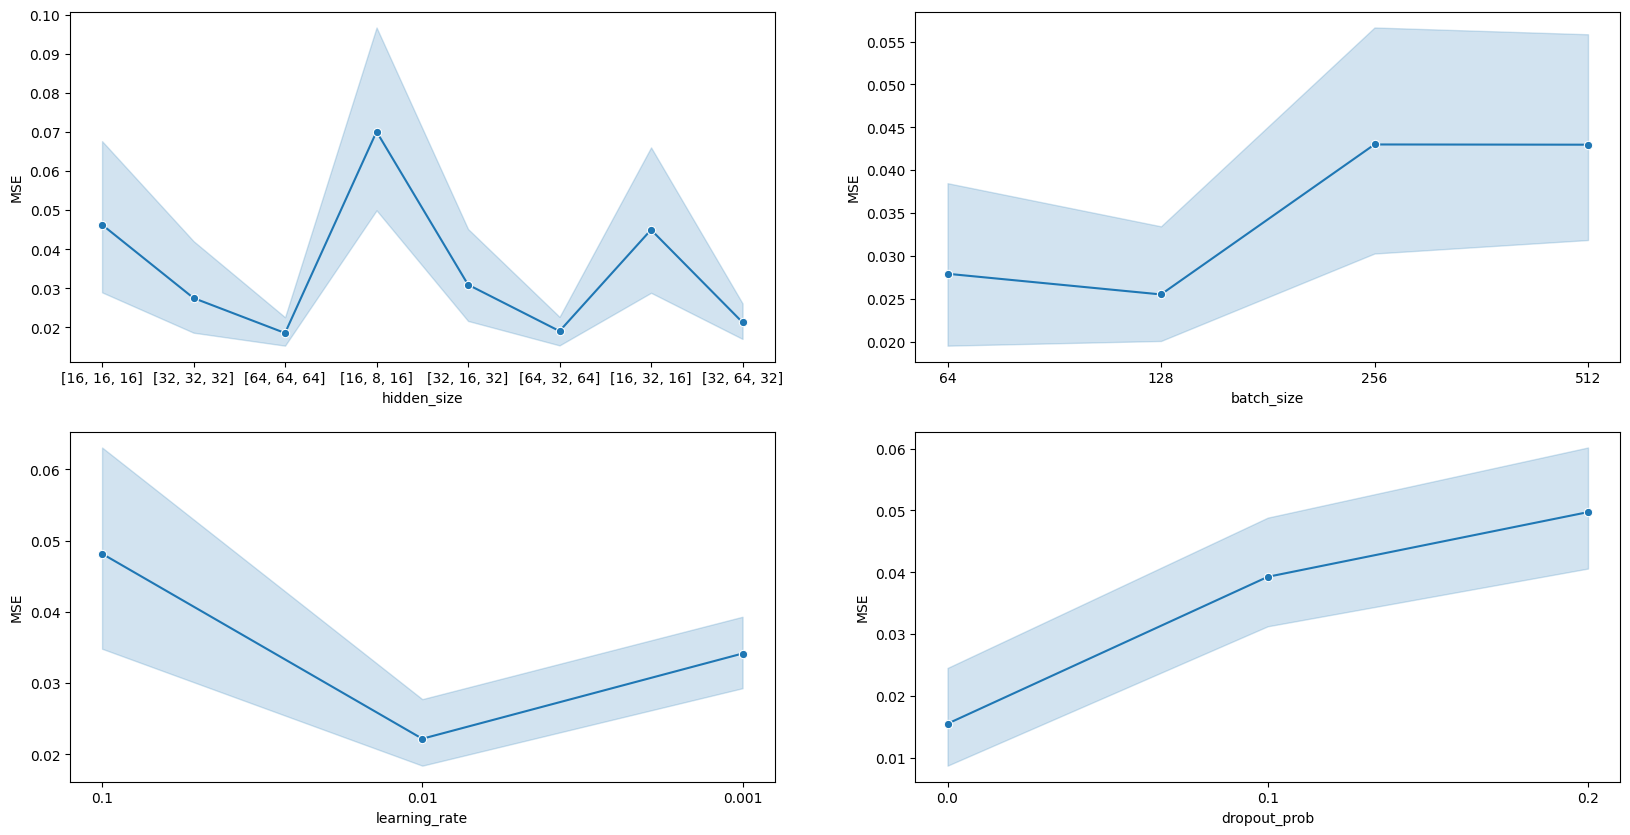

In [243]:
# plot x = [hidden_size, num_epochs, batch_size, learning_rate, dropout_prob], y = MSE

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.lineplot(x=my_table['hidden_size'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[0,0], marker='o')
sns.lineplot(x=my_table['batch_size'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[0,1], marker='o')
sns.lineplot(x=my_table['learning_rate'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[1,0], marker='o')
sns.lineplot(x=my_table['dropout_prob'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[1,1], marker='o')

plt.show()


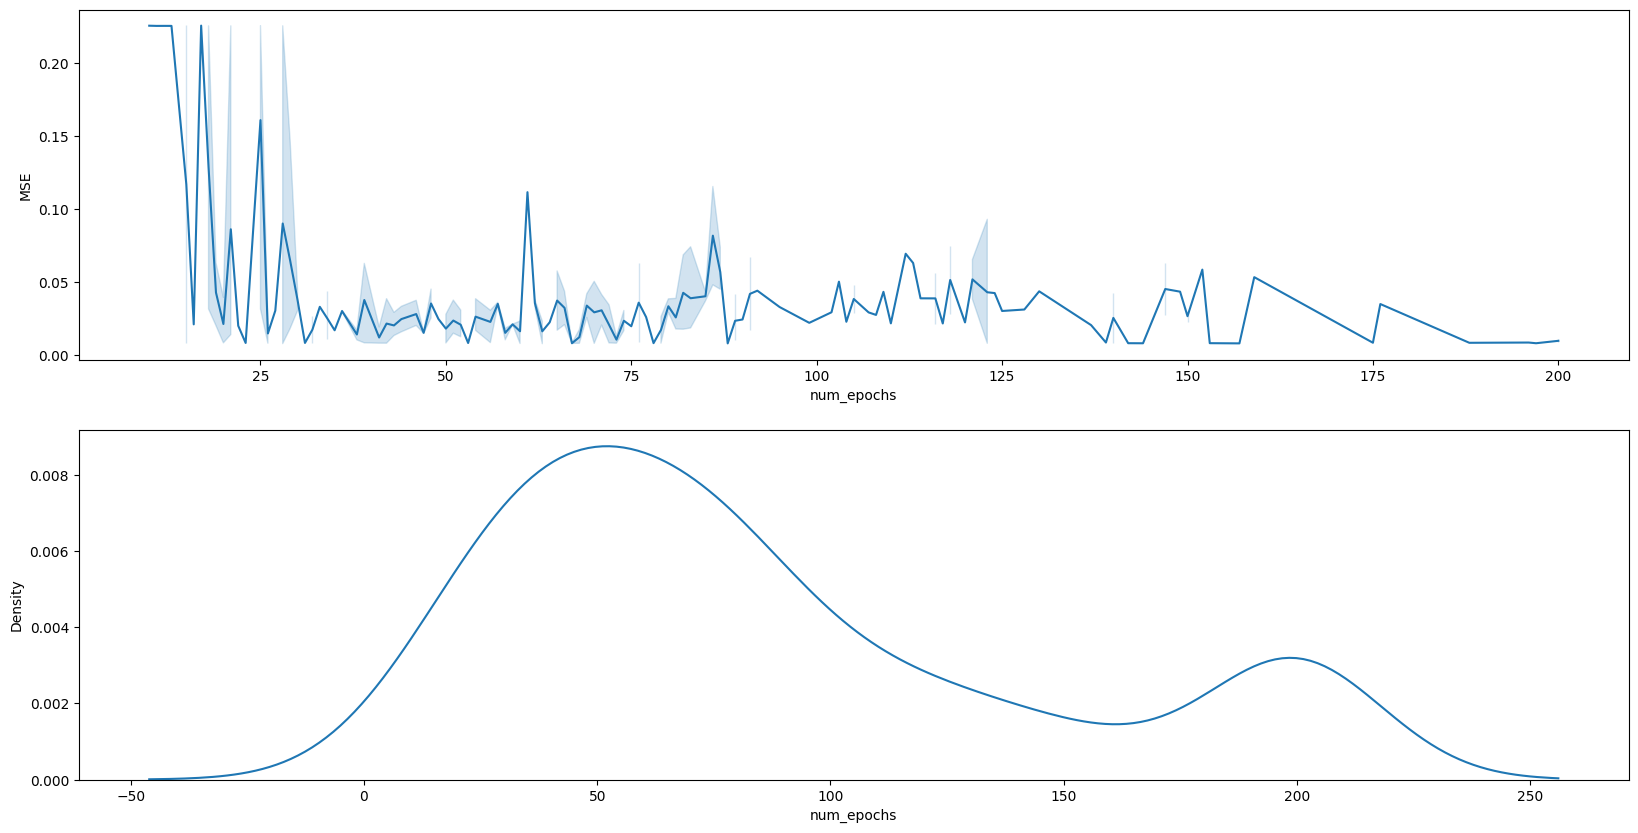

In [247]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.lineplot(x=my_table['num_epochs'], y='MSE', data=my_table, ax=axs[0])
sns.kdeplot(my_table['num_epochs'], ax=axs[1])

plt.show()

### Tabular

In [182]:
def print_metrics(y_true, y_pred, tag):
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if y_true.ndim>1:
        y_true=y_true.ravel()
    if y_pred.ndim>1:
        y_pred=y_pred.ravel()
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred)
    print(f"{tag} Acc: {val_acc} | {tag} F1: {val_f1}")


In [183]:
#data, cat_col_names, num_col_names = make_mixed_classification(n_samples=10000, n_features=20, n_categories=4)
train_tabular, test_tabular = train_test_split(df, random_state=42)
train_tabular, val_tabular = train_test_split(train_tabular, random_state=42)


In [184]:
label = ['mean_rating']
# continuous_columns is df.columns - (mean_rating, IMAX, Film-Noir)
categorical_columns = ['IMAX', 'Film-Noir']
continuous_columns = list(df.columns)
continuous_columns.remove('mean_rating')
continuous_columns.remove('IMAX')
continuous_columns.remove('Film-Noir')

print('df.columns:', list(df.columns))
print('continuous_columns:', continuous_columns)


df.columns: ['rating_count', 'mean_timestamp', 'absurd', 'action', 'adaptation', 'adapted from:book', 'adventure', 'affectionate', 'allegory', 'art', 'atmospheric', 'bad ending', 'bad plot', 'based on a book', 'based on book', 'beautiful scenery', 'beautifully filmed', 'betrayal', 'better than expected', 'bittersweet', 'bleak', 'books', 'breathtaking', 'brutality', 'catastrophe', 'cerebral', 'chase', 'childhood', 'cinematography', 'classic car', 'clever', 'comedy', 'complex', 'computer animation', 'corruption', 'creativity', 'crime gone awry', 'criterion', 'crude humor', 'cult classic', 'cult film', 'culture clash', 'death', 'depression', 'destiny', 'dialogue', 'distopia', 'disturbing', 'downbeat', 'drama', 'dramatic', 'dreamlike', 'drinking', 'dysfunctional family', 'earnest', 'emotional', 'enigmatic', 'entertaining', 'entirely dialogue', 'excellent script', 'exceptional acting', 'existentialism', 'family', 'fantasy world', 'feel good movie', 'feel-good', 'fight scenes', 'first contac

In [185]:
batch_size = 1024 #Will set the same in the Trainer YAML file
steps_per_epoch = int(train_tabular.shape[0]/1024)
epochs = 200

data_config = DataConfig(
    target=label, #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=continuous_columns,
    categorical_cols=categorical_columns,
)

optimizer_config = OptimizerConfig(lr_scheduler="OneCycleLR", lr_scheduler_params={"max_lr":0.00478, "epochs": epochs, "steps_per_epoch":steps_per_epoch})

head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming"
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = CategoryEmbeddingModelConfig(
    task="regression",
    layers="1024-512-512",
    activation="LeakyReLU",
    dropout=0.1,
    initialization="kaiming",
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config="trainer_config.yaml",
)


2023-03-18 08:21:20,605 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off


In [186]:
#tabular_model.fit(train=train, validation=val)
datamodule = tabular_model.prepare_dataloader(
                train=train_tabular, validation=val_tabular, seed=42
            )
model = tabular_model.prepare_model(
            datamodule
        )
tabular_model.train(model, datamodule)


2023-03-18 08:21:20,678 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
2023-03-18 08:21:20,681 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for regression task
2023-03-18 08:21:21,034 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: CategoryEmbeddingModel
2023-03-18 08:21:21,100 - {pytorch_tabular.tabular_model:264} - INFO - Preparing the Trainer
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-03-18 08:21:21,196 - {pytorch_tabular.tabular_model:558} - INFO - Auto LR Find Started


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=90` reached.
LR finder stopped early after 90 steps due to diverging loss.
Learning rate set to 0.0005248074602497723
Restoring states from the checkpoint path at /Users/biancaraimondi/Desktop/esami/DataAnalytics/progetto/data-analytics/.lr_find_739e5794-aaf0-4c2b-ac23-0419471ebfcd.ckpt
Restored all states from the checkpoint file at /Users/biancaraimondi/Desktop/esami/DataAnalytics/progetto/data-analytics/.lr_find_739e5794-aaf0-4c2b-ac23-0419471ebfcd.ckpt
2023-03-18 08:21:25,828 - {pytorch_tabular.tabular_model:560} - INFO - Suggested LR: 0.0005248074602497723. For plot and detailed analysis, use `find_learning_rate` method.
2023-03-18 08:21:25,829 - {pytorch_tabular.tabular_model:566} - INFO - Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  999 K │
│ 1 │ _embedding_layer │ Embedding1dLayer          │    416 │
│ 2 │ head             │ LinearHead                │    513 │
│ 3 │ loss             │ MSELoss                   │      0 │
└───┴──────────────────┴───────────────────────────┴────────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


2023-03-18 08:21:38,608 - {pytorch_tabular.tabular_model:568} - INFO - Training the model completed
2023-03-18 08:21:38,609 - {pytorch_tabular.tabular_model:1207} - INFO - Loading the best model


In [187]:
result = tabular_model.evaluate(test_tabular)


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.20649519562721252    │
│  test_mean_squared_error  │    0.20649519562721252    │
└───────────────────────────┴───────────────────────────┘

In [188]:
pred_df = tabular_model.predict(test_tabular)
pred_df.head()


Output()

,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,affectionate,allegory,art,...,weird,whimsical,witty,women,writers,IMAX,Film-Noir,year,mean_rating,mean_rating_prediction
10897,0.000184,0.837222,0.061901,0.038877,0.229619,0.325452,0.064591,0.397354,0.232721,0.633428,...,0.236243,0.066412,0.080172,0.804544,0.190298,0.0,0.0,0.926829,3.625000,2.737687
9044,0.001964,0.828752,0.212639,0.924562,0.163611,0.132040,0.201038,0.101323,0.056692,0.063549,...,0.116931,0.098388,0.170115,0.112058,0.070759,0.0,0.0,0.902439,3.015544,2.439833
7335,0.000282,0.577213,0.244496,0.274202,0.145557,0.180925,0.366537,0.152910,0.205799,0.045725,...,0.145238,0.074337,0.284195,0.061967,0.052533,0.0,0.0,0.552846,2.964286,2.357395
8180,0.007280,0.562718,0.200984,0.052266,0.479831,0.395058,0.063554,0.128307,0.109242,0.200982,...,0.730952,0.103580,0.168966,0.212239,0.371214,0.0,0.0,0.886179,3.425719,2.419599
10584,0.000958,0.758912,0.482517,0.133625,0.276446,0.204038,0.087160,0.691534,0.174476,0.339189,...,0.291005,0.872369,0.462644,0.786987,0.372554,0.0,0.0,0.926829,3.130631,3.037052


In [189]:
#print_metrics(test[label], pred_df["prediction"], tag="Holdout")


In [190]:
tabular_model.save_model("examples/basic")


In [191]:
loaded_model = TabularModel.load_from_checkpoint("examples/basic")


2023-03-18 08:21:39,817 - {pytorch_tabular.tabular_model:126} - INFO - Experiment Tracking is turned off
2023-03-18 08:21:39,819 - {pytorch_tabular.tabular_model:264} - INFO - Preparing the Trainer
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [192]:
result = loaded_model.evaluate(test_tabular)


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.20649519562721252    │
│  test_mean_squared_error  │    0.20649519562721252    │
└───────────────────────────┴───────────────────────────┘